# Bloqs Tutorial

Qualtran lets you represent high-level quantum programs and subroutines as a hierarchical
collection of Python objects. The main interface is the [`Bloq`](/reference/qualtran/Bloq.md) abstract base class.

In [1]:
import abc
from typing import *


class Bloq(metaclass=abc.ABCMeta):
    ...

We use a graph-like container to wire up collections of bloqs to define new bloqs.

By the end of this tutorial, you should understand how to declare bloqs, wire them up, use named registers, use high-bitsize registers, use 'bookkeeping' operations to split and join wires, represent allocations as operations in the graph, and use linear logic to prevent violations of the no cloning theorem.

## Basics

There are two important flavors of implementations of the [`Bloq`](/reference/qualtran/Bloq.md) interface. The first flavor
consists of bloqs implemented by you, the user-developer to express quantum operations of
interest. For example:

In [2]:
class ShorsAlgorithm(Bloq):
    ...

The other important [`Bloq`](/reference/qualtran/Bloq.md) subclass is [`CompositeBloq`](/reference/qualtran/CompositeBloq.md), which is a container type for a
collection of sub-bloqs. We'll investigate this class more later. First, let's define a
bloq for a simple quantum operation: the controlled-not (CNOT).

In [3]:
class CNOT(Bloq):
    ...

There is only one mandatory method we must implement to have a well-formed [`Bloq`](/reference/qualtran/Bloq.md). There
are many other methods we can optionally implement to encode more information about the
bloq, which we will add as we go along.

The mandatory method is the `Bloq.signature` property. This declares what the inputs and
outputs are for our bloq, and is a list of registers. A register has a name and quantum-type
information. By default, a register declares both an input and an output allowing quantum
data to pass through it, like the "control" register below. We call these `THRU` registers.

The `Bloq.signature` property can be thought of as analogous
to the function signature in ordinary programming. You can think of a bloq
with just this property implemented like a function
declarations in a C header (`*.h`) file.

In [4]:
from qualtran import Register

Register('control', bitsize=1)

Register(name='control', bitsize=1, shape=(), side=<Side.THRU: 3>)

The above declares a register named "control" with a size of 1. We'll return this as well
as a register for the "target" input/output of the CNOT bloq wrapped in the [`Signature`](/reference/qualtran/Signature.md)
container. <div class="alert alert-block alert-info">The `attrs.frozen` annotation removes some of the boilerplate to write an immutable Python class with a pre-defined set of attributes.</div>

In [5]:
import attrs
from qualtran import Bloq, Signature

@attrs.frozen
class CNOT(Bloq):
    @property
    def signature(self):
        return Signature([
            Register('control', bitsize=1),
            Register('target', bitsize=1),
        ])

We now have a well-formed bloq. We can instantiate it and visualize it.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


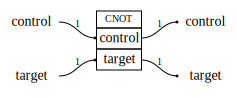

In [6]:
from qualtran.drawing import show_bloq

cnot = CNOT()
show_bloq(cnot)

This is the absolute minimum amount of information needed to define a Bloq: a name (i.e.
the class name) and a `signature` property. <div class="alert alert-block alert-warning">If you're familiar with Cirq, you can consider
a `cirq.Gate` to be analogous to a [`Bloq`](/reference/qualtran/Bloq.md) with one register named "qubits" of size `n`. In
fact, `CirqGateAsBloq` lets you wrap any Cirq gate in
this way.</div>

## Decomposing Bloqs

As you can probably guess, such a simple block-box model of an operation has limited utility.
We now turn our attention to a second bloq: SWAP -- which we will define in terms of its
decomposition into three CNOTs.

In [7]:
class SwapTwoBits(Bloq):
    ...

As before, we must define the function signature by naming and sizing the registers on
which it operates. We'll implement a bloq that swaps two (qu)bits. We'll name the arguments
`x` and `y`, but you have some creative freedom with these choices. <div class="alert alert-block alert-info">We've been filling in the `name` and `bitsize`
attributes for our registers. The other two attributes are for more advanced usage and
will be covered later. In simple cases, we could use the convenience method
`Signature.build(x=1, y=1)` for the same object below.</div>

In [8]:
class SwapTwoBits(Bloq):
    @property
    def signature(self):
        return Signature([
            Register('x', 1),
            Register('y', 1),
        ])

Now, for the moment you've been waiting for. We can define the implementation of SWAP in terms
of sub-operations. `Bloq.decompose_bloq()` will decompose a bloq into its component parts.
The return type of this operation is [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) -- our bloq container type which itself
follows the [`Bloq`](/reference/qualtran/Bloq.md) interface.

Instead of overriding `decompose_bloq()` directly, we override `build_composite_bloq`, which
makes it easier for you, the user-developer, to write decompositions.

In [9]:
from qualtran import BloqBuilder

class SwapTwoBits(Bloq):
    ...

    def build_composite_bloq(self, bb: BloqBuilder, *, x, y):
        ...

The bloqs infrastructure will pass in keyword arguments for each of the input registers,
here `x` and `y`. I stress that these names must match the names of the registers declared
in the `.signatures` property. The infrastructure also passes in a [`BloqBuilder`](/reference/qualtran/BloqBuilder.md)
which is what you will use to add suboperations to the composite bloq storing your
decomposition.

We use `bb.add(...)` to add sub-operations. For our swap operation, we will need to call
`add` three times for each of the CNOTs. The signature is: `bb.add(bloq, **bloq_args)` where
the first argument is an instantiation of the bloq we want to add, and then keyword arguments
providing the input quantum variables. This call will return quantum variables representing
the outputs of the operation that are suitable for using as inputs to subsequent operations.

The method returns a dictionary mapping (output) register names to the final quantum variables.

In [10]:
class SwapTwoBits(Bloq):
    @property
    def signature(self):
        return Signature([
            Register('x', 1),
            Register('y', 1),
        ])

    def build_composite_bloq(self, bb: BloqBuilder, *, x, y):
        x, y = bb.add(CNOT(), control=x, target=y)
        y, x = bb.add(CNOT(), control=y, target=x)
        x, y = bb.add(CNOT(), control=x, target=y)
        return {'x': x, 'y': y}

Note that each CNOT operation takes two arguments named "control" and "target" and returns
two quantum variables which are ordered according to the ordering of the registers
in `CNOT.signature` (so in this case: control, target).

Let's see what this looks like.

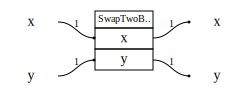

In [11]:
swap = SwapTwoBits()
show_bloq(swap)

Wait! This is still just a two-bit black box! I thought we defined the bloq by its decomposition.
The Bloq object always represents the atomic operation and [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) always represents
a collection of sub-operations. We have to explicitly request the decomposition if that's
what we want to visualize.

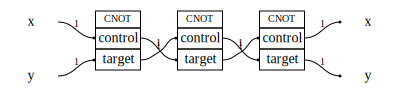

In [12]:
show_bloq(swap.decompose_bloq())

### Using [`BloqBuilder`](/reference/qualtran/BloqBuilder.md) directly

You can build a standalone [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) (i.e. not as part of the decomposition of
another bloq) as well. This can come in handy for testing or prototyping. Simply
instantiate a [`BloqBuilder`](/reference/qualtran/BloqBuilder.md). You need to manually
manage your registers with `bb.add_register(...)` and you must finish your building session
by calling `bb.finalize(...)` to freeze your composite-bloq-under-construction into an
immutable [`CompositeBloq`](/reference/qualtran/CompositeBloq.md).

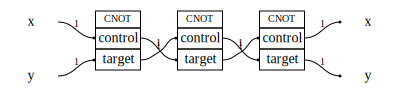

In [13]:
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)
x, y = bb.add(CNOT(), control=x, target=y)
y, x = bb.add(CNOT(), control=y, target=x)
x, y = bb.add(CNOT(), control=x, target=y)
cbloq = bb.finalize(x=x, y=y)
show_bloq(cbloq)

## Quantum variables and [`Soquet`](/reference/qualtran/Soquet.md)s.

What are the types of `x` and `y`? They represent quantum variables used to "wire up" sub
operations by providing them as inputs and receiving them as outputs during calls to `bb.add`. <div class="alert alert-block alert-warning">If you're familiar with Cirq, you might think
that they are equivalent to `cirq.Qubit`s. Whereas a cirq.Circuit has a fixed pool of qubits
on which many operations act, these quantum variables follow different rules &mdash; read on!</div>

The rules of quantum mechanics makes these quantum variables behave very differently than
normal variables. The most salient rules are the no-cloning theorem and its dual, the
[no-deleting theorem](https://en.wikipedia.org/wiki/No-deleting_theorem). In the parlance
of programming language research, our variables follow "linear logic". A linear variable
must be used once and only once.

The following snippets show improper use of our quantum variables. Luckily, the bloq builder will
raise an error if the rules of quantum mechanics are not followed!

In [14]:
from qualtran import BloqError

bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)

try:
    _ = bb.add(CNOT(), control=x, target=x)
except BloqError as e:
    print("Can't use a variable as both control and target!")
    print(e)

Can't use a variable as both control and target!
LeftDangle.x is not an available Soquet for `CNOT().target`.


In [15]:
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)
x2, y2 = bb.add(CNOT(), control=x, target=y)

try:
    x3, y3 = bb.add(CNOT(), control=x, target=y)
except BloqError as e:
    print("`x` and `y` were consumed by the first call to `add`.")
    print("Returned quantum variables are *new, immutable* variables that you use")
    print("in subsequent operations")
    print(e)

`x` and `y` were consumed by the first call to `add`.
Returned quantum variables are *new, immutable* variables that you use
in subsequent operations
LeftDangle.x is not an available Soquet for `CNOT().control`.


In [16]:
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)

# The following line turns on the additional checks needed to
# raise an exception in this case:
bb.add_register_allowed = False

x2, y2 = bb.add(CNOT(), control=x, target=y)
x3, y3 = bb.add(CNOT(), control=x2, target=y2)

try:
    bb.finalize(x=x3)
except BloqError as e:
    print("Any unused variables must be 'passed on' to `finalize` to be outputs.")
    print(e)

Any unused variables must be 'passed on' to `finalize` to be outputs.
Finalizing requires a Soquet named `y`.


The actual Python type of these objects is [`Soquet`](/reference/qualtran/Soquet.md), which you will see in type annotations,
but you should never instantiate a [`Soquet`](/reference/qualtran/Soquet.md) directly, nor should you use or set its attributes.
Soquets should be constructed and managed by [`BloqBuilder`](/reference/qualtran/BloqBuilder.md) and other infrastructure. <div class="alert alert-block alert-warning">Another opaque, infrastructural class that
    you may see but should not be manipulating directly is [`BloqInstance`](/reference/qualtran/BloqInstance.md). This simple wrapper
lets us distinguish between two *instances* of e.g. a CNOT bloq. Usually we want value
equality semantics between bloqs.</div>

## Larger registers

Our two bloqs have still been operating at the level of individual bits. We now consider
a general swap between two `n`-sized registers. <div class="alert alert-block alert-info">The `n: int` line means our class has one attribute named `n` of type `int`. The attrs annotation will automatically generate an `__init__` function.</div>

In [17]:
@attrs.frozen
class Swap(Bloq):
    n: int

    @property
    def signature(self):
        return Signature([
            Register('x', bitsize=self.n),
            Register('y', bitsize=self.n),
        ])

Note that our bloq now has an attrs attribute `n` that lets us configure the exact parameters
of the bloq without defining a new class. This is analogous to a template parameter in C++,
for example. Bloqs should be immutable and hashable.

In [18]:
assert Swap(5) == Swap(5)
assert Swap(5) != Swap(6)

In [19]:
from qualtran import SoquetT

@attrs.frozen
class Swap(Bloq):
    n: int

    @property
    def signature(self):
        return Signature.build(x=self.n, y=self.n)

    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        # THIS WON'T ACTUALLY WORK! Read on.
        for i in range(self.n):
            x[i], y[i] = bb.add(SwapTwoBits(), x=x[i], y=y[i])
        return {'x': x, 'y': y}

For our first attempt, we will straightforwardly decompose our swap between two n-bit registers
into n swaps over each bit in the two registers. There's a note that this won't actually work.
Let's see what happens.

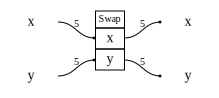

In [20]:
show_bloq(Swap(n=5))

That looks fine... In fact: you can see a useful property of bloqs. Instead of representing
each qubit as its own quantum variable, the size of our register is just a property annotated
on the graph. We can make it arbitrarily large with no performance penalty

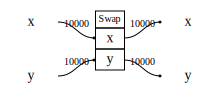

In [21]:
show_bloq(Swap(n=10_000))

The problem occurs when we decompose our bloq.

In [22]:
import traceback

try:
    cbloq = Swap(n=5).decompose_bloq()
except TypeError as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/var/folders/3l/4zd2bgl54gb8xfx5hn66g6fr00m48r/T/ipykernel_61734/2679143270.py", line 4, in <module>
    cbloq = Swap(n=5).decompose_bloq()
  File "/Users/mpharrigan/qutran/qutran/qualtran/_infra/bloq.py", line 138, in decompose_bloq
    return _decompose_from_build_composite_bloq(self)
  File "/Users/mpharrigan/qutran/qutran/qualtran/_infra/bloq.py", line 40, in _decompose_from_build_composite_bloq
    out_soqs = bloq.build_composite_bloq(bb=bb, **initial_soqs)
  File "/var/folders/3l/4zd2bgl54gb8xfx5hn66g6fr00m48r/T/ipykernel_61734/1590169855.py", line 16, in build_composite_bloq
    x[i], y[i] = bb.add(SwapTwoBits(), x=x[i], y=y[i])
TypeError: 'Soquet' object is not subscriptable



Can you figure out what's happening? The very advantage alluded to above has come back
to bite us! If we have one object representing an n-bit register, we can't index into it
to do bit-twiddling in our decomposition. We'll take a second look at [`Register`](/reference/qualtran/Register.md) to see
if we can modify our signature declaration to make this work.

[`Register`](/reference/qualtran/Register.md) can represent an n-dimensional array of quantum bits. For example, I can
declare a 3x3 matrix of 32-bit quantum variables:

In [23]:
arr_reg = Register('arr', bitsize=32, shape=(3, 3))
print('total bits:', arr_reg.total_bits())

total bits: 288


<div class="alert alert-block alert-info">`shape` is like `np.ndarray.shape`.</div>

In computing, we can think of all data as an ndarray of bits or qubits, but -- analogous to
classical data types -- it's preferable to treat a certain number of bits (or qubits) as
our atomic datatype. For example, in C, an array of `int32 x[10];` does not let you index
into individual bits like `x[3][31]`. Unlike in C, you are not limited by machine word size
for atomic type sizes, which is why above we could define a register of `bitsize=5`.

In the `SwapTwoBits` example everything was `bitsize=1` and we could write our decomposition
without slicing into the registers. Let's write a version of `Swap` that uses an array
of `bitsize=1` values.

In [24]:
@attrs.frozen
class SwapManyBits(Bloq):
    n: int

    @property
    def signature(self):
        # Not ideal; read on.
        return Signature([
            Register('x', bitsize=1, shape=(self.n,)),
            Register('y', bitsize=1, shape=(self.n,)),
        ])

    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        for i in range(self.n):
            x[i], y[i] = bb.add(SwapTwoBits(), x=x[i], y=y[i])
        return {'x': x, 'y': y}

Now since we've moved our `n` dimension of our inputs into the `shape` part of
the register declaration, slicing should work:

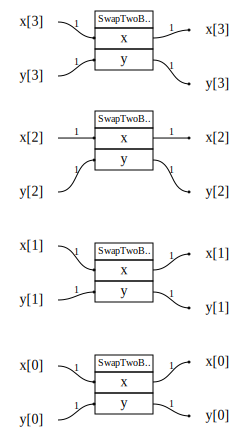

In [25]:
cbloq = SwapManyBits(n=4).decompose_bloq()
show_bloq(cbloq)

The problem is now we (once again) have a Python object constructed for each bit:

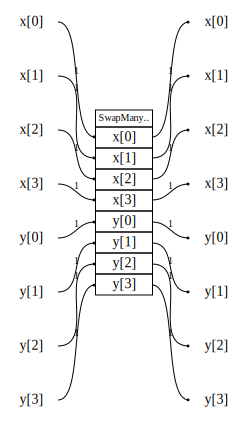

In [26]:
show_bloq(SwapManyBits(n=4))

<div class="alert alert-block alert-info">Forget about trying to show `n=10_000`.</div>

Can we have the best of both worlds? Yes: the general technique is to represent the Bloq
definition in as high-level terms as practical and use `bb.split(...)` and `bb.join(...)`
to break apart registers during decomposition. This way a user can use the Bloq as a black-box
without incurring the performance overhead of representing each bit if they do not care about
the decomposition. If they *are* interested in the decomposition, then the cost will only be
paid when actually doing the decomposition.

In [27]:
@attrs.frozen
class Swap(Bloq):
    n: int

    @property
    def signature(self):
        return Signature.build(x=self.n, y=self.n)

    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        xs = bb.split(x)
        ys = bb.split(y)

        for i in range(self.n):
            xs[i], ys[i] = bb.add(SwapTwoBits(), x=xs[i], y=ys[i])
        return {
            'x': bb.join(xs),
            'y': bb.join(ys),
        }

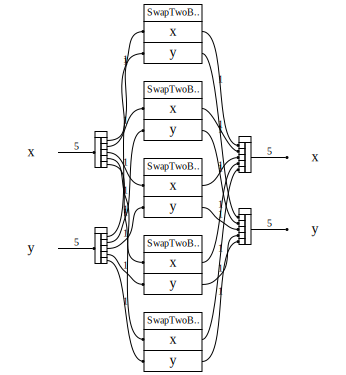

In [28]:
cbloq = Swap(n=5).decompose_bloq()
show_bloq(cbloq)

The interleaved wires can get a little confusing. An alternative method of visualization via the familiar "musical score" diagram is also available

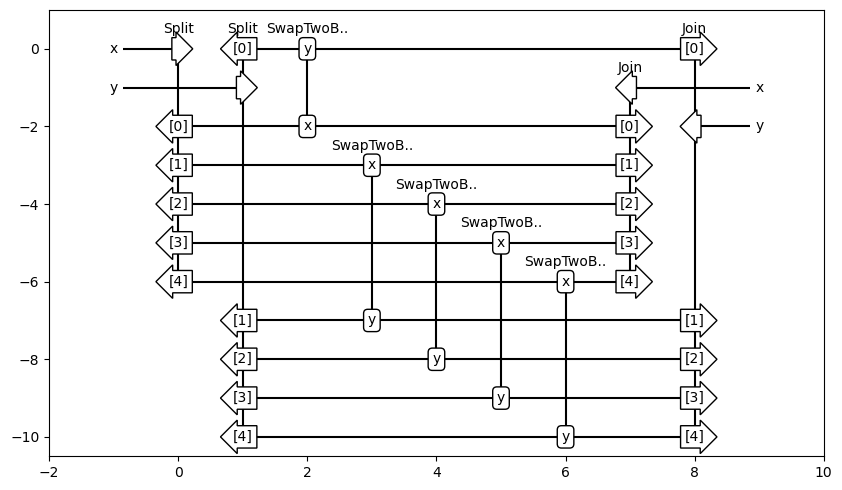

In [29]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.set_figwidth(9)

## Allocations and de-allocations

We can encode operations that allocate and/or de-allocate quantum data as well. Each [`Register`](/reference/qualtran/Register.md) has an attribute called `side`. By default, it is set to `THRU` meaning that the quantum data moves through the register and that register is available for use as both an input and an output.

In [30]:
reg = Register('ctrl', 1)
reg.side

<Side.THRU: 3>

### `LEFT` and `RIGHT`

We can declare registers that are input-only ("LEFT") or output-only ("RIGHT"). Pure-state quantum evolution is unitary; so using registers like these implies you're encoding a non-unitary operation. For example: bloqs which allocate a new qubit or discard an existing qubit would have asymmetric registers.

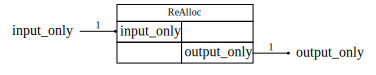

In [31]:
from qualtran import Side

@attrs.frozen
class ReAlloc(Bloq):
    @property
    def signature(self):
        return Signature([
            Register('input_only', bitsize=1, side=Side.LEFT),
            Register('output_only', bitsize=1, side=Side.RIGHT),
        ])
    
show_bloq(ReAlloc())

Of course, the signature *only* provides the `side` of the register. It is up to the bloq author to give it functionality by providing a decomposition or annotating it with simulation information. We'll use the `State` and `Effect` one-qubit bloqs provided by the library to explore their behavior under simulation.

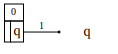

array([1.+0.j, 0.+0.j])

In [32]:
from qualtran.bloqs.basic_gates import ZeroState

# Show a simple allocating bloq and its tensor representation
show_bloq(ZeroState())
ZeroState().tensor_contract()

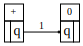

0.4999999999999999

In [33]:
from qualtran.bloqs.basic_gates import PlusState, ZeroEffect

bb = BloqBuilder()

# Wire up <+|0>
q = bb.add(PlusState())
bb.add(ZeroEffect(), q=q)

# Show it and find its probability
cbloq = bb.finalize()
show_bloq(cbloq)
cbloq.tensor_contract() ** 2

## Algorithms

We've been looking at small, familiar bloqs to get acquainted with the functionality. Bloqs can represent quantum operations at any level of complexity, but are particularly useful for reasoning about high-level algorithms. For example, Qualtran includes a reference implementation of modular exponentiation (the limiting operation for Shor's factoring)

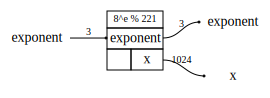

In [34]:
from qualtran.bloqs.factoring import ModExp

mod_exp = ModExp(base=8, mod=13*17, exp_bitsize=3, x_bitsize=1024)
show_bloq(mod_exp)

High-level bloqs should be defined in terms of only-slightly-less high-level bloqs to keep each step of the decomposition understandable. The `ModExp` bloq's decomposition is:

In [35]:
def build_composite_bloq(self, bb: 'BloqBuilder', exponent: 'SoquetT') -> Dict[str, 'SoquetT']:
    x = bb.add(IntState(val=1, bitsize=self.x_bitsize))
    exponent = bb.split(exponent)

    # https://en.wikipedia.org/wiki/Modular_exponentiation#Right-to-left_binary_method
    base = self.base
    for j in range(self.exp_bitsize - 1, 0 - 1, -1):
        exponent[j], x = bb.add(self._CtrlModMul(k=base), ctrl=exponent[j], x=x)
        base = base * base % self.mod

    return {'exponent': bb.join(exponent), 'x': x}

In addition to decomposing and visualizing, we can use other protocols to query properties of the bloq or test its correctness. 

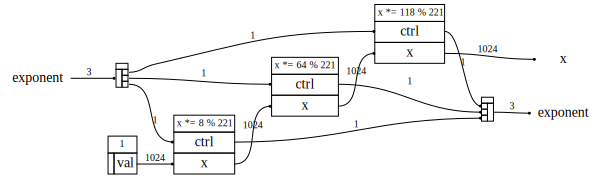

In [36]:
show_bloq(mod_exp.decompose_bloq())

## Bloq protocols

Bloqs support a growing list of protocols that let you annotate a given [`Bloq`](/reference/qualtran/Bloq.md) with more
definitions or known information. In the following table we summarize the available protocols. Please note that the method you override as a bloq writer is often different than the method you call as a bloq user.

| What                 | Call this                   | Override this               | Docs                                                    |
|----------------------|-----------------------------|-----------------------------|---------------------------------------------------------|
| Bloq decomposition   | `decompose_bloq()`          | `build_composite_bloq(...)` | [Composite bloq](/_infra/composite_bloq.ipynb)          |
| Numerical simulation | `tensor_contract()`         | `add_my_tensors(...)`       |                                                         |
| Classical simulation | `call_classically(**vals)`  | `on_classical_vals(...)`    | [Classical simulation](/simulation/classical_sim.ipynb) |
| Resource counting    | `bloq_counts()`             | `bloq_counts()`             | [Bloq counts](/resource_counting/bloq_counts.ipynb)     |
| Conversion to Cirq   | `to_cirq_circuit(**quregs)` | `as_cirq_op(...)`           | [Cirq Interop](/cirq_interop/cirq_interop.ipynb)        |